#### Import Libraries

In [29]:
import cv2
import matplotlib.pyplot as plt
import os
import csv

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import shutil
from torchvision import models
# !pip install torchinfo
# from torchinfo import summary
from torchvision.models import resnet18
import math
from difflib import SequenceMatcher

In [30]:
# check if we are using gpu or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Data Fetching

In [ ]:
# downloading the iam-handwriting-word-database
# which can be found here https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nibinv23/iam-handwriting-word-database
os.mkdir("/content/dataset")
!unzip /content/iam-handwriting-word-database.zip -d /content/dataset

In [32]:
MIN_LABEL_LENGTH = 3
MAX_LABEL_LENGTH = 9

raw = list()
for i, line in enumerate(open("/content/dataset/words_new.txt")):
  if i < 19: continue # commented lines - need to ignore them
  line_array = line.split(" ")
  path = line_array[0] # gives the path
  status = line_array[1] # gives the status of the file
  label = line_array[-1] # gives the true label of the image
  if status == "ok":
    label = label[:-1]

    #only keep labels that are of length 3 - 9
    if len(label) < MIN_LABEL_LENGTH or len(label) > MAX_LABEL_LENGTH: continue

    #only keep lables that dont have any special characters
    special = any(not c.isalpha() for c in label)
    if not special:
      example = (path, label)
      raw.append(example)

In [33]:
# Unknown Character: 00
# Block Letters: 01-26
# Small Letters: 27-52

def encode_label(label):
  #convert each alphabet to its corresponding ascii value

  encoded_label = list()

  for character in label:
    encoded_character = 0

    if character.isalpha():
      if character.upper() == character: encoded_character = ord(character) - 64
      elif character.lower() == character: encoded_character = ord(character) - 70

    else:
      print("WHOOPS!")

    encoded_label.append(encoded_character)
  return encoded_label

def decode_label(array):
  # exact opposite of encode lables, it converts ascii characters to alphabets
  decoded_word = ""
  for idx in array:
    idx = int(idx)
    decoded_char = "&"
    if idx == 0: decoded_char = "_"
    elif idx <= 26: decoded_char = chr(idx+64)
    elif idx <= 52: decoded_char = chr(idx+70)
    decoded_word = decoded_word + decoded_char
  return decoded_word


def pad_label(label):
  #pad the labels to the max length of 9 to ensure every lable has the same length
  pad_len = MAX_LABEL_LENGTH - len(label)
  padding = [0] * pad_len
  padded_label = label + padding
  return padded_label

Path of the example image:  a01/a01-000u/a01-000u-00-01.png
Encoded lable of the example image:  [13, 15, 22, 5, 0, 0, 0, 0, 0]
Example Image:


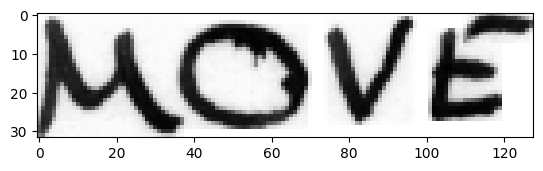

In [34]:
path, label = raw[0]
array = path.split("-")
subfolder = array[0] + "-" + array[1]
base_path = "/content/dataset/iam_words/words/"
new_path = array[0] + "/" + subfolder + "/" +path + ".png"
print("Path of the example image: ", new_path)

encoded = encode_label(label)
padded = pad_label(encoded)
print("Encoded lable of the example image: ", padded)

img = cv2.imread(base_path+new_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 32))
print("Example Image:")
plt.imshow(img, cmap='gray')


In [39]:
def remove_duplicates(list_of_substrings):
  ans = list()

  for substring in list_of_substrings:
    unique_substring = ""
    for i in range(len(substring)):
      if i==0: unique_substring = unique_substring + substring[i]
      elif substring[i-1] != substring[i]: unique_substring = unique_substring + substring[i]
    ans.append(unique_substring)

  return ans


def decode_labels(outputs):
  ans = list()

  for pred in outputs:
    decoded_word = decode_label(pred)
    list_of_substrings = decoded_word.split("&")
    list_of_unique_substrings = remove_duplicates(list_of_substrings)
    decoded_word = "".join(list_of_unique_substrings)

    for i, char in enumerate(decoded_word):
      if char == "_": continue
      decoded_word = decoded_word[i:]
      break
    decoded_word = decoded_word.split("_")[0]

    ans.append(decoded_word)

  return ans

def decode_truths(outputs):
  ans = list()

  for pred in outputs:
    decoded_word = decode_label(pred)
    decoded_word = decoded_word.split("_")[0]
    ans.append(decoded_word)

  return ans

def similar(a, b):
  return SequenceMatcher(None, a, b).ratio()

In [36]:
dataset = list()
base_path = "/content/dataset/iam_words/words/"

for example in raw:
  path, label = example
  array = path.split("-")
  subfolder = array[0] + "-" + array[1]
  new_path = array[0] + "/" + subfolder + "/" +path + ".png"

  img = cv2.imread(base_path+new_path, cv2.IMREAD_GRAYSCALE)
  if img is None: continue
  img = cv2.resize(img, (128, 32))
  img = torch.Tensor(img)
  img = img.to(device)

  encoded = encode_label(label)
  padded = pad_label(encoded)
  padded = torch.Tensor(padded)
  padded = padded.to(device)

  dataset.append((img, padded))

In [37]:
dataset_length = len(dataset)
train_data_length = int(0.90*dataset_length)
valid_data_length = int(0.05*dataset_length)
test_data_length = dataset_length - train_data_length - valid_data_length

train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_data_length, valid_data_length, test_data_length])

#### Model Building


In [21]:
class HandwritingRecogCRNN_new(nn.Module):
    def __init__(self):
        super(HandwritingRecogCRNN_new, self).__init__()
        self.name = "handwriting_recog_correct"
        self.conv1 = nn.Conv2d(1, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)

        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)

        self.conv4 = nn.Conv2d(256, 256, 3, padding = 1)
        self.pool2 = nn.MaxPool2d((2,1))
        self.conv5 = nn.Conv2d(256, 512, 3, padding = 1)
        self.batch_norm = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 3, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 2)
        self.bidirection_lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers= 2, bidirectional = True, dropout = 0.2)
        self.rnn1 = nn.GRU(input_size=512,
                            hidden_size=256,
                            bidirectional=True,
                            batch_first=True)
        self.fc1 = nn.Linear(256, 54)

    def forward(self, x):
        x = x.float().unsqueeze(dim=1)
        # x = x.squeeze(2)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.batch_norm(x)
        x = F.relu(self.conv6(x))
        x = self.pool2(self.batch_norm2(x))
        x = F.relu(self.conv7(x))
        x = x.squeeze()
        x = torch.transpose(x, 1, 2)

        x, _ = self.bidirection_lstm(x)

        # # x = x.view(-1, 10 * 53 * 53)
        x = F.log_softmax(self.fc1(x))
        return x

In [22]:
# Baseline model that can classify images to different labels
class HandwrittenClassifierBaseline(nn.Module):
    def __init__(self):
        super(HandwrittenClassifierBaseline, self).__init__()
        self.name = "handwritten_classifier"
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 50, 5)
        self.fc1 = nn.Linear(50 * 5 * 29, 30)
        self.fc2 = nn.Linear(30, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 50 * 5 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### Model Training Helper Functions

In [24]:
def get_data_loader(batch_size=64):
  train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
  testr_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

  return train_loader, valid_loader, testr_loader

def get_model_name(name, batch_size, learning_rate, epoch):
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
  return path

In [25]:
def evaluate(net, loader, criterion, batch_size=64):
    total_loss = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        outputs = torch.transpose(outputs, 0, 1)
        input_lengths = torch.IntTensor([outputs.size(0)] * outputs.size(1))
        target_lengths = torch.IntTensor([len(i) for i in labels])
        loss = criterion(outputs, labels, input_lengths, target_lengths)
        total_loss += loss.item()
        total_epoch += len(labels)
    loss = float(total_loss) / (i + 1)
    return loss

def plot_training_curve(path):
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss)

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

from torch.nn.modules.loss import SmoothL1Loss

def get_accuracy(model, data):
    threshold = math.log(0.0005)
    correct, total = 0, 0
    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        max_val, max_idx = torch.max(output,2)
        for j in range(len(output)):
          val = max_val[j]
          idx = max_idx[j]
          for i in range(len(val)):
              if val[i] < threshold:
                idx[i] = 0
          max_idx[j] = idx
        prediction = decode_labels(max_idx)

        truth = decode_truths(labels)
        for i in range(len(prediction)):
          # print("prediction: ", prediction[i], "   ground truth: ", truth[i])
          correct += similar(prediction[i], truth[i])
          total += 1
    return correct / total

In [26]:
def load_pretrained_model(num_epochs, batch_size=64, learning_rate=0.01):
  state = torch.load("/content/model_handwriting_recog_correct_bs"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs-1))
  new_model = HandwritingRecogCRNN_new()
  new_model.load_state_dict(state)
  new_model.to(device)
  return new_model

In [27]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):

    torch.manual_seed(1000)
    train_loader, val_loader, test_loader = get_data_loader(batch_size)
    criterion = nn.CTCLoss(blank=53, zero_infinity=True)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc, valid_acc = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            outputs = torch.transpose(outputs, 0, 1)

            input_lengths = torch.IntTensor([outputs.size(0)] * outputs.size(1))
            target_lengths = torch.IntTensor([len(i) for i in labels])
            loss = criterion(outputs, labels, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            loss_item = loss.item()
            total_train_loss += loss_item
            total_epoch += len(labels)

        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(net, val_loader, criterion, batch_size)
        train_acc.append(get_accuracy(net, train_loader))
        valid_acc.append(get_accuracy(net, val_loader))
        print(("Epoch {}: Train loss: {}, Train acc: {} |"+
               "Validation loss: {}, Validation acc: {}").format(
                   epoch + 1,
                   train_loss[epoch],
                   train_acc[-1],
                  # 0,
                   val_loss[epoch],
                   valid_acc[-1]
                  # 0
                  ))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        #lr_scheduler.step(train_loss[epoch])

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [40]:
# Example to start training model:

model = HandwritingRecogCRNN_new()
model = model.to(device)
train_net(net = model, batch_size=64, learning_rate=0.001, num_epochs=10)

<ipython-input-21-899a9c504234>:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc1(x))


Epoch 1: Train loss: 11.637594493482844, Train acc: 0.08820082919254592 |Validation loss: 11.273288798332214, Validation acc: 0.08742205711879115
Epoch 2: Train loss: 11.494970208303087, Train acc: 0.10110304677249468 |Validation loss: 11.139177751541137, Validation acc: 0.10020101833089747
Epoch 3: Train loss: 11.299433347333029, Train acc: 0.13827529351888615 |Validation loss: 10.937200784683228, Validation acc: 0.1395120226188611
Epoch 4: Train loss: 11.122697469105438, Train acc: 0.17225352998311824 |Validation loss: 10.788286328315735, Validation acc: 0.17781024533082695
Epoch 5: Train loss: 10.992397511108763, Train acc: 0.16734695458548576 |Validation loss: 10.689129376411438, Validation acc: 0.17251632515535276
Epoch 6: Train loss: 10.89396577784953, Train acc: 0.1707167547946649 |Validation loss: 10.58661346435547, Validation acc: 0.17347455826676955
Epoch 7: Train loss: 10.820117026050657, Train acc: 0.18043366587001664 |Validation loss: 10.53924651145935, Validation acc: 0.1